# MNIST Image Classification with TensorFlow

In [1]:
from sklearn.datasets import fetch_mldata
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/Users/sashakapralov/anaconda3/envs/py36_2/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


### LOAD DATA

In [6]:
mnist = fetch_mldata('MNIST original')

In [7]:
X = mnist.data
y = mnist.target

In [22]:
m = len(X)
perm = np.random.permutation(m)

In [27]:
x_train, x_test = X[perm][10000:], X[perm][:10000]
y_train, y_test = y[perm][10000:], y[perm][:10000]

x_train = x_train / 255
x_test = x_test / 255

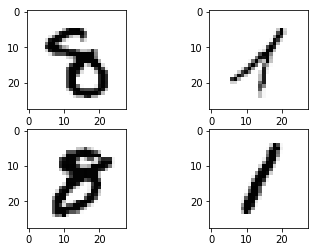

In [28]:
f, ax = plt.subplots(2,2)
ax[0, 0].imshow(X[50000].reshape(28,28), cmap='Greys')
ax[0, 1].imshow(X[61199].reshape(28,28), cmap='Greys')
ax[1, 0].imshow(X[50420].reshape(28,28), cmap='Greys')
ax[1, 1].imshow(X[61933].reshape(28,28), cmap='Greys')
plt.show()

### DATA AUGMENTATION

In [29]:
from scipy.ndimage.interpolation import shift

In [30]:
def shift_image(image, dx, dy):
    image = image.reshape((28,28))
    shifted_image = shift(image, [dx, dy], cval = 0, mode='constant')
    return shifted_image.reshape([-1])

In [31]:
x_train_shift = []
y_train_augmented = []

#shift images by 1 pixel right, left, up and down
for dx, dy in ((1,0),(-1,0),(0,1),(0,-1)):
    for image, label in zip(x_train, y_train):
        x_train_shift.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

In [32]:
x_train_shift = np.array(x_train_shift)
y_train_augmented = np.array(y_train_augmented)

In [33]:
x_train_shift.shape, y_train_augmented.shape

((240000, 784), (240000,))

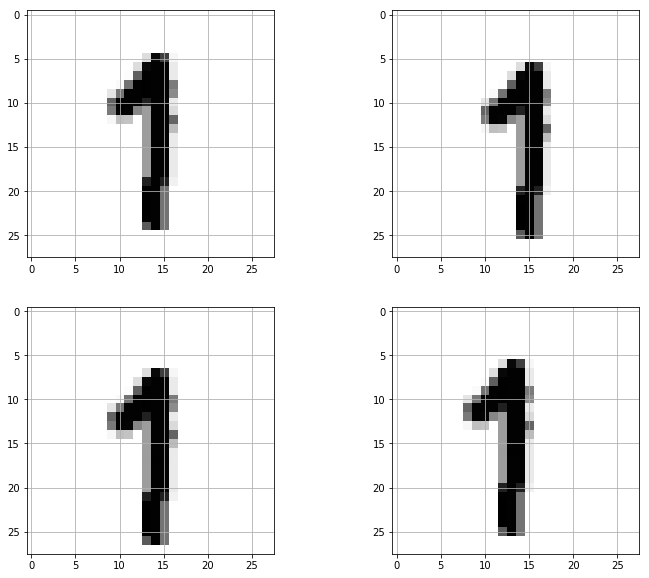

In [34]:
f, ax = plt.subplots(2,2, figsize=(12,10))
ax[0, 0].imshow(x_train_shift[60001].reshape(28,28), cmap='Greys')
ax[1, 0].imshow(x_train_shift[1].reshape(28,28), cmap='Greys')
ax[0, 1].imshow(x_train_shift[120001].reshape(28,28), cmap='Greys')
ax[1, 1].imshow(x_train_shift[180001].reshape(28,28), cmap='Greys')
ax[0, 0].grid()
ax[1, 0].grid()
ax[0, 1].grid()
ax[1, 1].grid()

In [35]:
import cv2

In [36]:
def horizontal_flip(images):
    flipped_images = []
    for img in images:
        flipped_img = cv2.flip(img, flipCode = 1) #1 means flip around y-axis
        flipped_images.append(flipped_img)
    return (flipped_images)

In [37]:
flipped_imgs = horizontal_flip(x_train.reshape(-1,28,28))

In [38]:
flipped_imgs = np.array(flipped_imgs)
flipped_labels = np.array(y_train[:])

In [39]:
flipped_imgs = flipped_imgs.reshape(-1,28,28)

In [40]:
flipped_imgs.shape, flipped_labels.shape

((60000, 28, 28), (60000,))

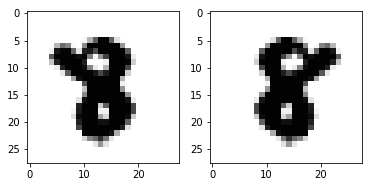

In [44]:
f, ax = plt.subplots(1,2)
ax[0].imshow(flipped_imgs[100].reshape(28,28), cmap='Greys')
ax[1].imshow(x_train[100].reshape(28,28), cmap='Greys')
plt.show()

### NEURAL NETWORK

In [45]:
#helper function for feeding random mini batches to neural network
def shuffle_batch(x, y, batch_size):
    rnd_idx = np.random.permutation(len(x))
    n_batches = len(x)//batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        x_batch, y_batch = x[batch_idx], y[batch_idx]
        yield x_batch, y_batch

In [51]:
tf.reset_default_graph()

In [52]:
with tf.name_scope('placeholders'):
    
    X = tf.placeholder(np.float32, shape=[None,28,28], name='X')
    X_reshaped = tf.reshape(X, [-1,28,28,1], name='X_reshaped')
    y = tf.placeholder(np.int32, shape=None, name='y')

In [53]:
with tf.name_scope('conv'):
    
    conv1 = tf.layers.conv2d(X_reshaped, 12, [3,3], strides=1, padding='SAME', name='conv1') #12 feature maps, 3x3 filter
    pool1 = tf.layers.max_pooling2d(conv1, [3,3], strides=2, name='pool1')
    
    conv2 = tf.layers.conv2d(pool1, 16, [3,3], strides=1, padding='SAME', name='conv2')
    pool2 = tf.layers.max_pooling2d(conv2, [3,3], strides=2, name='pool2')
    
    pool2_flatten = tf.reshape(pool2, shape=(-1,6*6*16))
    
    fc1 = tf.layers.dense(pool2_flatten, 256, activation = tf.nn.selu, name = 'fc1')
    fc2 = tf.layers.dense(fc1, 100, activation = tf.nn.selu, name = 'fc2')
    
    logits = tf.layers.dense(fc2, 10, activation = tf.nn.selu, name = 'output')

In [54]:
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)

In [55]:
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(0.001)
    training_op = optimizer.minimize(loss)

In [56]:
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, np.float32))

In [57]:
import time

In [59]:
batch_size = 128

out = []

start_time = time.time()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    out = []
    for epoch in range(20):
        for x_batch, y_batch in shuffle_batch(x_train, y_train, batch_size):
            sess.run(training_op, feed_dict = {X: x_batch.reshape((-1,28,28)), y:  y_batch})
        batch_acc = accuracy.eval(feed_dict = {X: x_batch.reshape((-1,28,28)), y:  y_batch})
        val_acc = accuracy.eval(feed_dict = {X: x_test.reshape((-1,28,28)), y:  y_test})
        print(epoch, "Batch Accuracy =", batch_acc, "Validation Accuracy =", val_acc)
        outputs = sess.run(logits, feed_dict = {X: x_test.reshape((-1,28,28))})
        out.append(outputs)
        
print("Elapsed Time: ", (time.time() - start_time)/60., "Minutes")

0 Batch Accuracy = 0.9609375 Validation Accuracy = 0.974
1 Batch Accuracy = 0.9765625 Validation Accuracy = 0.983
2 Batch Accuracy = 0.984375 Validation Accuracy = 0.9808
3 Batch Accuracy = 0.9921875 Validation Accuracy = 0.9872
4 Batch Accuracy = 0.984375 Validation Accuracy = 0.9872
5 Batch Accuracy = 1.0 Validation Accuracy = 0.9864
6 Batch Accuracy = 0.9921875 Validation Accuracy = 0.9864
7 Batch Accuracy = 0.9921875 Validation Accuracy = 0.9879
8 Batch Accuracy = 1.0 Validation Accuracy = 0.9869
9 Batch Accuracy = 1.0 Validation Accuracy = 0.988
10 Batch Accuracy = 0.9921875 Validation Accuracy = 0.9869
11 Batch Accuracy = 1.0 Validation Accuracy = 0.9888
12 Batch Accuracy = 1.0 Validation Accuracy = 0.9864
13 Batch Accuracy = 1.0 Validation Accuracy = 0.9899
14 Batch Accuracy = 1.0 Validation Accuracy = 0.9892
15 Batch Accuracy = 0.9921875 Validation Accuracy = 0.99
16 Batch Accuracy = 1.0 Validation Accuracy = 0.9903
17 Batch Accuracy = 1.0 Validation Accuracy = 0.9908
18 Batch 

### NEURAL NETWORK WITH SHIFTED/FLIPPED FEATURES AND DROPOUT AND BATCH NORMALIZATION

In [80]:
tf.reset_default_graph()

In [81]:
with tf.name_scope('placeholders'):
    
    X = tf.placeholder(np.float32, shape=[None,28,28], name='X')
    X_reshaped = tf.reshape(X, [-1,28,28,1], name='X_reshaped')
    y = tf.placeholder(np.int32, shape=None, name='y')
    
    bn1_train = tf.placeholder_with_default(True, shape = (None), name = 'bn1_holder')
    bn2_train = tf.placeholder_with_default(True, shape = (None), name = 'bn2_holder')
    
    drop1 = tf.placeholder_with_default(True, shape=(None), name = 'Drop1')
    drop2 = tf.placeholder_with_default(True, shape=(None), name = 'Drop2')

In [82]:
with tf.name_scope('conv'):
    
    conv1 = tf.layers.conv2d(X_reshaped, 12, [3,3], strides=1, padding='SAME', name='conv1') #12 feature maps, 3x3 filter
    pool1 = tf.layers.max_pooling2d(conv1, [3,3], strides=2, name='pool1')
    bn1 = tf.layers.batch_normalization(pool1, training = bn1_train, momentum=0.9)
    dropout1 = tf.layers.dropout(bn1, 0.5, training=drop1)
    
    conv2 = tf.layers.conv2d(pool1, 16, [3,3], strides=1, padding='SAME', name='conv2')
    pool2 = tf.layers.max_pooling2d(conv2, [3,3], strides=2, name='pool2')
    bn2 = tf.layers.batch_normalization(pool2, training = bn2_train, momentum=0.9)
    dropout2 = tf.layers.dropout(bn2, 0.5, training=drop2)
    
    bn2_flatten = tf.reshape(dropout2, shape=(-1,6*6*16))
    
    fc1 = tf.layers.dense(bn2_flatten, 256, activation = tf.nn.selu, name = 'fc1')
    fc2 = tf.layers.dense(fc1, 100, activation = tf.nn.selu, name = 'fc2')
    
    logits = tf.layers.dense(fc2, 10, activation = tf.nn.selu, name = 'output')

In [83]:
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)

In [84]:
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(0.001)
    training_op = optimizer.minimize(loss)

In [85]:
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, np.float32))

In [73]:
flipped_imgs_784 = flipped_imgs.reshape((-1,784))

In [76]:
final_x = np.concatenate((x_train,flipped_imgs_784,x_train_shift),axis=0)

In [77]:
final_x.shape

(360000, 784)

In [78]:
final_y = np.concatenate((y_train,flipped_labels,y_train_augmented),axis=0)

In [79]:
final_y.shape

(360000,)

In [86]:
batch_size = 128

out = []

start_time = time.time()

extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    out = []
    for epoch in range(30):
        for x_batch, y_batch in shuffle_batch(final_x, final_y, batch_size):
            sess.run([training_op, extra_update_ops], feed_dict = {X: x_batch.reshape((-1,28,28)), y:  y_batch})
        batch_acc = accuracy.eval(feed_dict = {X: x_batch.reshape((-1,28,28)), y:  y_batch})
        val_acc = accuracy.eval(feed_dict = {bn1_train: False, bn2_train: False,
                                             drop1: False, drop2: False,
                                             X: x_test.reshape((-1,28,28)), y:  y_test})
        print(epoch, "Batch Accuracy =", batch_acc, "Validation Accuracy =", val_acc)
        outputs = sess.run(logits, feed_dict = {bn1_train: False, bn2_train: False,
                                                drop1: False, drop2: False,
                                                X: x_test.reshape((-1,28,28))})
        out.append(outputs)
        
print("Elapsed Time: ", (time.time() - start_time)/60., "Minutes")

0 Batch Accuracy = 0.9765625 Validation Accuracy = 0.9868
1 Batch Accuracy = 0.96875 Validation Accuracy = 0.9915
2 Batch Accuracy = 0.9765625 Validation Accuracy = 0.9903
3 Batch Accuracy = 1.0 Validation Accuracy = 0.9915
4 Batch Accuracy = 0.9765625 Validation Accuracy = 0.993
5 Batch Accuracy = 0.984375 Validation Accuracy = 0.9928
6 Batch Accuracy = 0.9921875 Validation Accuracy = 0.993
7 Batch Accuracy = 0.9921875 Validation Accuracy = 0.9938
8 Batch Accuracy = 1.0 Validation Accuracy = 0.9936
9 Batch Accuracy = 0.9765625 Validation Accuracy = 0.9933
10 Batch Accuracy = 0.9921875 Validation Accuracy = 0.9937
11 Batch Accuracy = 0.9921875 Validation Accuracy = 0.9939
12 Batch Accuracy = 0.9921875 Validation Accuracy = 0.9942
13 Batch Accuracy = 1.0 Validation Accuracy = 0.9935
14 Batch Accuracy = 0.9921875 Validation Accuracy = 0.9943
15 Batch Accuracy = 1.0 Validation Accuracy = 0.9932
16 Batch Accuracy = 1.0 Validation Accuracy = 0.9938
17 Batch Accuracy = 1.0 Validation Accurac

In [88]:
outputs.shape

(10000, 10)

In [89]:
outputs[:2]

array([[-1.7456344 , -1.7364352 , 21.808788  , -0.7079118 , -1.7580441 ,
         2.0966947 ,  1.3200657 ,  2.8535185 , -1.7098682 , -1.7555516 ],
       [-1.7564293 ,  0.32909518, -1.5901555 , -0.99869424,  7.754143  ,
         1.9115486 , -1.7555888 ,  4.7840185 ,  4.0362124 , 16.540876  ]],
      dtype=float32)

In [90]:
y_hat = np.argmax(outputs, axis=1)

In [92]:
y_hat.shape

(10000,)

In [93]:
y_hat[:2]

array([2, 9])

In [97]:
y_test[:2]

array([2., 9.])

In [94]:
from sklearn.metrics import accuracy_score

In [96]:
accuracy_score(y_test, y_hat)

0.9923